In [2]:
# import the libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from tqdm import tqdm
from scipy.optimize import minimize
from hurst import compute_Hc
import warnings
warnings.filterwarnings("ignore")

In [3]:
def rsi(value, neutral, window):
	"""

	Input:
	:param value: (type dataframe pandas): Entry values of the stock
	:param neutral:(float) Value of the neutrality, i.e No Action Zone
	:param window: (float) rolling period for RSI calculation

	Output: The function gives the returns of RSI strategy
	:return:
	"""
	# Print error is no Adj Close column is not present
	if "Adj Close" not in value.columns:
		ValueError("Error: No Adj Close column is present")

	value['rsi'] = ta.momentum.RSIIndicator(value['Adj Close'], window=window).rsi()

	"""Long Buy signal"""
	overbuy = 70
	neutral_buy = 50 + neutral

	# Put nan values for te signal long columns
	value['signal_long'] = np.nan
	value['yesterday_rsi'] = value['rsi'].shift(1)
	# We need to define open long signal (Rsi yes>55 and RSI today>55)
	value.loc[(value['rsi'] > neutral_buy) & (value['yesterday_rsi'] < neutral_buy), 'signal_long'] = 1
	# open long signal for false positive (Rsi yes>55 and RSI today<55)
	value.loc[(value['rsi'] < neutral_buy) & (value['yesterday_rsi'] > neutral_buy), 'signal_long'] = 0
	# open long signal for overbuy (Rsi yes>70 and RSI today<70)
	value.loc[(value['rsi'] < overbuy) & (value['yesterday_rsi'] > overbuy), 'signal_long'] = 0

	"""Short Sell signal"""
	oversell = 30
	neutral_sell = 50 - neutral

	# Put the values for the short signal columns
	value['signal_short'] = np.nan

	# We define the Open short signal (RSI yes>45 and RSI today<45)
	value.loc[(value['rsi'] < neutral_sell) & (value['yesterday_rsi'] > neutral_sell), 'signal_short'] = -1

	# We define the Close short signal(Rsi yes<45 and RSI today>45) False signal
	value.loc[(value['rsi'] > neutral_sell) & (value['yesterday_rsi'] < neutral_sell), 'signal_short'] = 0

	# We define the Close short signal (RSI yes<30 and RSI today>30) Oversell
	value.loc[(value['rsi'] < oversell) & (value['yesterday_rsi'] > oversell), 'signal_short'] = 0

	"""Compute the returns"""
	# Compute the percentage of the variation of the stock
	value['pct'] = value['Adj Close'].pct_change(1)

	# Calculate the position
	value['Position'] = (value['signal_short'].fillna(method='ffill') + value['signal_long'].fillna(method='ffill'))

	# Compute the returns
	value['return'] = value['pct'] * (value['Position'].shift(1))

	return value['return']

[*********************100%***********************]  1 of 1 completed


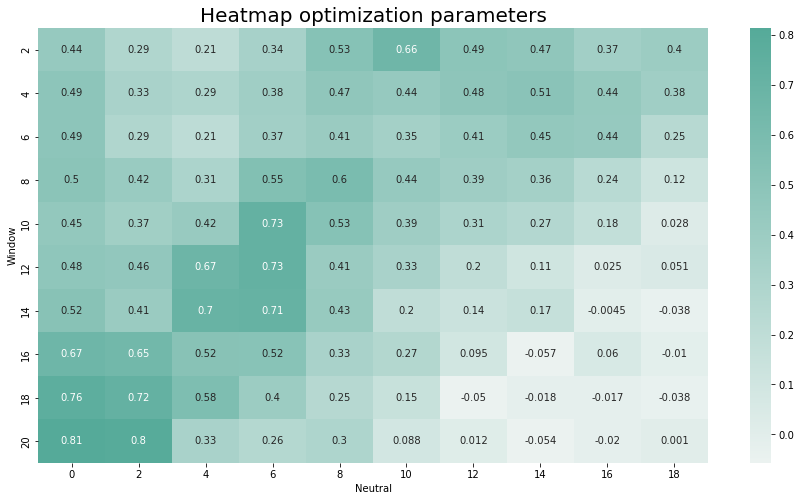

In [15]:
# Finding the best Hyper Parameter
# Heatmap of the best hyperparameter

data = yf.download('GOOG')

# set list for possible values of neutral and window
neutral_values = [i*2 for i in range(0,10)]
window_values = [i*2 for i in range(1,11)]

# set matrix with zeros
grid = np.zeros([len(neutral_values),len(window_values)])

# Calculate the return strategy for each combo
for i in range(len(neutral_values)):
	for j in range(len(window_values)):
		return_rsi = rsi(data,neutral_values[i],window_values[j])  # compute the return RSI
		grid[i][j] = np.sqrt(252) * return_rsi.mean() / (return_rsi[return_rsi<0].std() + 0.00001)

# Adapt the size
plt.figure(figsize=(15,8))

# Palette color for heatmap
palette = sns.color_palette("light:#5A9", as_cmap=True)

# Plot the map
sns.heatmap(grid,annot=True,xticklabels=neutral_values,yticklabels=window_values,cmap=palette)

plt.title("Heatmap optimization parameters", size=20)
plt.xlabel("Neutral")
plt.ylabel("Window")
plt.show()

In [17]:
def grid_param(data):
	# set list for possible values of neutral and window
	neutral_values = [i*2 for i in range(0,10)]
	window_values = [i*2 for i in range(1,11)]

	# set matrix with zeros
	grid = np.zeros([len(neutral_values),len(window_values)])

	# Calculate the return strategy for each combo
	for i in range(len(neutral_values)):
		for j in range(len(window_values)):
			return_rsi = rsi(data,neutral_values[i],window_values[j])  # compute the return RSI
			grid[i][j] = np.sqrt(252) * return_rsi.mean() / (return_rsi[return_rsi<0].std() + 0.00001)

	# return the grid
	return grid